# <style> 
    .ma-classe {
    font-size: 40 px;
}
</style>
<div class="alert alert-warning">  Load Librairies </div>



In [2]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)


import csv
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt

import sklearn.metrics

#  <style> 
    .ma-classe {
    font-size: 40px;
}
</style>
<div class="alert alert-danger">1 |</span></b> Load the data </div>

In [146]:
train_set_600 = []
for idx in range(225):
    name = 'data/data_bert_600/train/tensor' + str(idx) + '.csv' 
    tensor = torch.load(name)
    train_set_600 += tensor

In [147]:
val_set_600 = []
for idx in range(55):
    name = 'data/data_bert_600/val/tensor' + str(idx) + '.csv' 
    tensor = torch.load(name)
    val_set_600 += tensor

In [32]:
train_set_215 = []
for idx in range(40):
    name = 'data/data_bert_215/train/tensor' + str(idx) + '.csv' 
    tensor = torch.load(name)
    train_set_215 += tensor

In [33]:
val_set_215 = []
for idx in range(20):
    name = 'data/data_bert_215/val/tensor' + str(idx) + '.csv' 
    tensor = torch.load(name)
    val_set_215 += tensor

In [14]:
val_set_cut_5 = []
for idx in range(10):
    name = 'data/cut/cut_bert/cut_5/tensor' + str(idx) + '.pt' 
    tensor = torch.load(name)
    val_set_cut_5 += tensor

In [15]:
val_set_cut_10 = []
for idx in range(10):
    name = 'data/cut/cut_bert/cut_10/tensor' + str(idx) + '.pt' 
    tensor = torch.load(name)
    val_set_cut_10 += tensor

In [16]:
val_set_cut_20 = []
for idx in range(10):
    name = 'data/cut/cut_bert/cut_20/tensor' + str(idx) + '.pt' 
    tensor = torch.load(name)
    val_set_cut_20 += tensor

In [17]:
val_set_cut_50 = []
for idx in range(10):
    name = 'data/cut/cut_bert/cut_50/tensor' + str(idx) + '.pt' 
    tensor = torch.load(name)
    val_set_cut_50 += tensor

#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success">2.1 |</span></b> Define the model and usefull functions  </div>



In [18]:
#PRE_TRAINED_MODEL_NAME = 'Rostlab/prot_bert_bfd_localization'
class ProteinClassifier(nn.Module):
    def __init__(self, bert_hidden_size, mlp_hidden, n_classes):
        super(ProteinClassifier, self).__init__()
        
        self.bert_hidden_size = bert_hidden_size
        
        self.g = nn.Sequential(
            nn.Linear(self.bert_hidden_size, mlp_hidden),
            nn.ReLU(),
            nn.Linear(mlp_hidden, mlp_hidden),
            nn.ReLU(),
        )
        
        
        self.f = nn.Sequential(
            nn.Linear(mlp_hidden, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(mlp_hidden, n_classes),
            nn.Sigmoid()
        )
        
    def forward(self, bert_og, bert_mut, bert_mask):#input_):
        b = self.g(bert_mask)
        c = self.g(bert_mut)
        d = b + c #abs(a-b)
        output = self.f(d)
        return output

In [130]:
def predict(data, model_):
    target_list = []
    pred_list = []
    for bert_og, bert_mut, bert_mask, tags, _ in data:


        target = torch.tensor(float(tags)).unsqueeze(0).unsqueeze(0)


        scores = model_(bert_og, bert_mut, bert_mask)
        
        target_list += [target.item()]
        pred_list += [scores.round().item()]
        
    acc = sklearn.metrics.accuracy_score(target_list, pred_list)
    
    return target_list, pred_list, acc

In [164]:
def predict_for_plot(data, model_):
    target_list = []
    pred_list = []
    data_with_pred = []
    for bert_og, bert_mut, bert_mask, tags, info in data:


        target = torch.tensor(float(tags)).unsqueeze(0).unsqueeze(0)

        scores = model_(bert_og, bert_mut, bert_mask)
    
        target_list += [target.item()]
        pred_list += [scores.round().item()]
    
        data_with_pred += [(bert_og, bert_mut, bert_mask, tags, int(scores.round().item()), info)]
    
    return data_with_pred

In [159]:
from utils.conf_matrix import make_confusion_matrix
from utils.plot_histogram import plot_histogram

#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success">2.2 |</span></b> Training  </div>




#  <style> 
    .ma-classe {
    font-size: 10px;
}
</style>
<div class="alert alert-success">2.2.1 |</span></b> Training data_215  </div>





In [194]:
bert_config_hidden_size = 1024

In [195]:
model_215 = ProteinClassifier(bert_config_hidden_size, 256,1)




In [196]:
loss_function = nn.BCELoss()#torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor([1.]))#nn.NLLLoss()
optimizer_215 = optim.Adam(model_215.parameters(), lr=0.000001)

In [197]:
target_list, pred_list, acc = predict(val_set_215, model_215)
acc

0.5287958115183246

In [199]:
#sequences already encoded in training set
print_ = 0


for epoch in range(100):  
    loss_epoch = []
    for bert_og, bert_mut, bert_mask, tags, _ in train_set_215:
        #optimize.zero
        
        target = torch.tensor(float(tags)).unsqueeze(0).unsqueeze(0)
        
        # Step 3. Run our forward pass.
        
        scores = model_215(bert_og, bert_mut, bert_mask)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        
        loss = loss_function(scores, target)
        loss.backward()
        optimizer_215.step()
        
        loss_epoch += [loss.item()]
        
    
    if epoch % 1 == 0:
        print('Epoch n°', epoch, ':')
        _, _, acc = predict(val_set_215, model_215)
        print('Loss avg epoch :', sum(loss_epoch) / len(loss_epoch))
        print('Accuracy :', acc)

Epoch n° 0 :
Loss avg epoch : 0.5841923263233999
Accuracy : 0.675392670157068
Epoch n° 1 :
Loss avg epoch : 0.5572252606307652
Accuracy : 0.7172774869109948
Epoch n° 2 :
Loss avg epoch : 0.5475267822135457
Accuracy : 0.7120418848167539
Epoch n° 3 :
Loss avg epoch : 0.5302724405586846
Accuracy : 0.7120418848167539
Epoch n° 4 :
Loss avg epoch : 0.529140020669021
Accuracy : 0.7225130890052356
Epoch n° 5 :
Loss avg epoch : 0.5180539290907136
Accuracy : 0.7329842931937173
Epoch n° 6 :
Loss avg epoch : 0.5128284892188342
Accuracy : 0.7382198952879581
Epoch n° 7 :
Loss avg epoch : 0.5091907197076233
Accuracy : 0.7591623036649214
Epoch n° 8 :
Loss avg epoch : 0.5007755459129802
Accuracy : 0.743455497382199
Epoch n° 9 :
Loss avg epoch : 0.5060281420387873
Accuracy : 0.743455497382199
Epoch n° 10 :
Loss avg epoch : 0.5047498138832797
Accuracy : 0.743455497382199
Epoch n° 11 :
Loss avg epoch : 0.49608645313954247
Accuracy : 0.7120418848167539
Epoch n° 12 :
Loss avg epoch : 0.49317384375577444
Acc

#  <style> 
    .ma-classe {
    font-size: 10px;
}
</style>
<div class="alert alert-success">2.2.2 |</span></b> Training data_600  </div>






In [200]:
bert_config_hidden_size = 1024

In [201]:
model_600 = ProteinClassifier(bert_config_hidden_size, 256,1)





In [202]:
loss_function = nn.BCELoss()#torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor([1.]))#nn.NLLLoss()
optimizer_600 = optim.Adam(model_600.parameters(), lr=0.000001)

In [203]:
target_list, pred_list, acc = predict(val_set_600, model_600)
acc

0.5735430157261795

In [204]:
#pred_list

In [205]:
#sequences already encoded in training set
print_ = 0


for epoch in range(50):  
    loss_epoch = []
    for bert_og, bert_mut, bert_mask, tags, _ in train_set_600:
        optimizer.zero_grad()
        
        target = torch.tensor(float(tags)).unsqueeze(0).unsqueeze(0)
        
        # Step 3. Run our forward pass.
        
        scores = model_600(bert_og, bert_mut, bert_mask)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        
        loss = loss_function(scores, target)
        loss.backward()
        optimizer_600.step()
        
        loss_epoch += [loss.item()]
        
    
    if epoch % 1 == 0:
        print('Epoch n°', epoch, ':')
        _, _, acc = predict(val_set_600, model_600)
        print('Loss avg epoch :', sum(loss_epoch) / len(loss_epoch))
        print('Accuracy :', acc)

Epoch n° 0 :
Loss avg epoch : 0.5612167942846531
Accuracy : 0.7816836262719704
Epoch n° 1 :
Loss avg epoch : 0.4689809589917557
Accuracy : 0.8112858464384829
Epoch n° 2 :
Loss avg epoch : 0.4295693860164457
Accuracy : 0.8140610545790934
Epoch n° 3 :
Loss avg epoch : 0.4103777222474395
Accuracy : 0.8140610545790934
Epoch n° 4 :
Loss avg epoch : 0.39455120744569316
Accuracy : 0.8288621646623496
Epoch n° 5 :
Loss avg epoch : 0.3845654500989957
Accuracy : 0.845513413506013
Epoch n° 6 :
Loss avg epoch : 0.3769289331895456
Accuracy : 0.8408880666049954
Epoch n° 7 :
Loss avg epoch : 0.3686900886523681
Accuracy : 0.8445883441258094
Epoch n° 8 :
Loss avg epoch : 0.364351460740502
Accuracy : 0.8371877890841813
Epoch n° 9 :
Loss avg epoch : 0.35996818275139675
Accuracy : 0.8390379278445883
Epoch n° 10 :
Loss avg epoch : 0.3516748897185727
Accuracy : 0.845513413506013
Epoch n° 11 :
Loss avg epoch : 0.35150236515315936
Accuracy : 0.8436632747456059
Epoch n° 12 :
Loss avg epoch : 0.34970664667575596

#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success">3. |</span></b> Measure performances  </div>





#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success">3.1 |</span></b> On the 600 dataset  </div>





In [206]:
target, pred, acc = predict(val_set_600, model_600)

In [207]:
cf_matrix = sklearn.metrics.confusion_matrix(target, pred)
cf_matrix

array([[565,  22],
       [108, 386]])

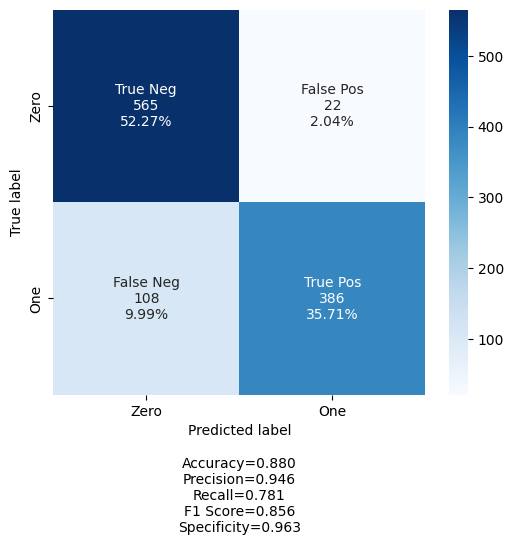

In [208]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
plt.rcParams["figure.figsize"] = (6,5)
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      )

In [209]:
for_hist = predict_for_plot(val_set_600, model_600)

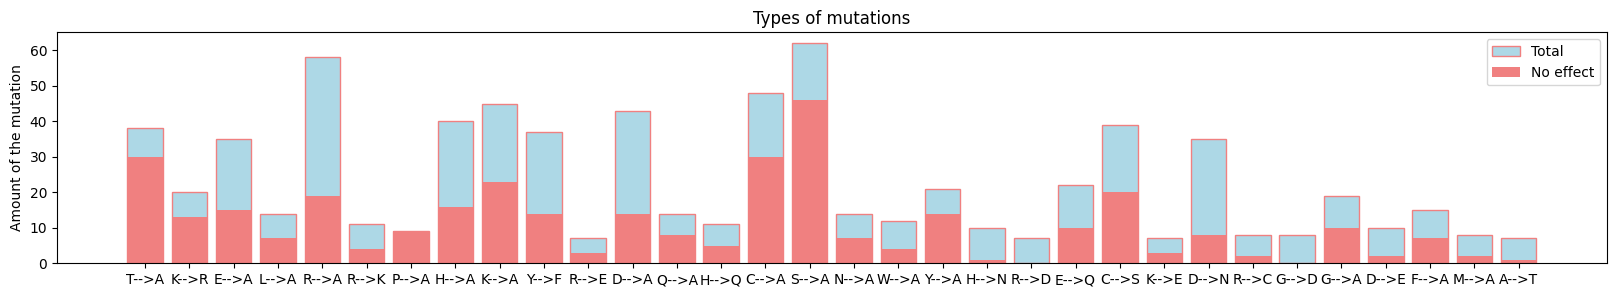

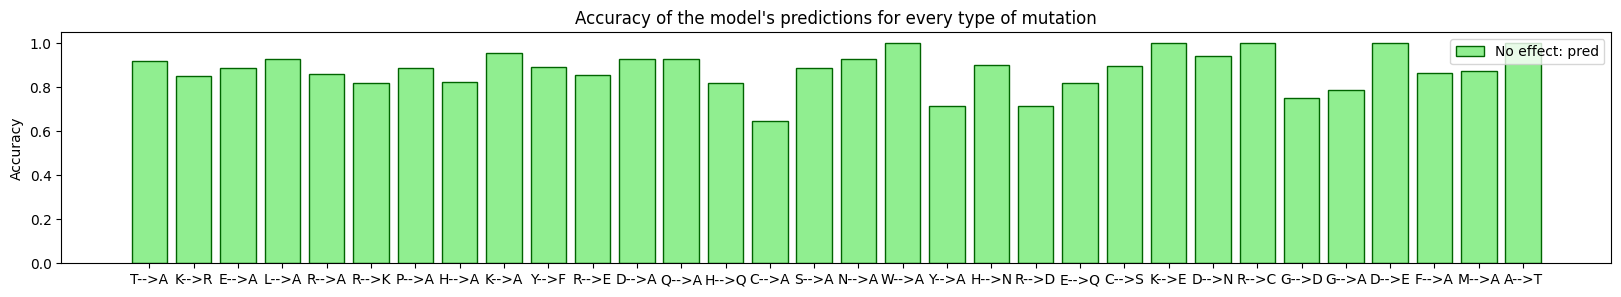

In [210]:
amount_min_of_each_plotted_mutation = 6
plot_histogram(for_hist, amount_min_of_each_plotted_mutation)

#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success">3.1 |</span></b> On the 215 dataset and its cuts  </div>






#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success">3.1.1 |</span></b> Full 215 dataset  </div>







In [211]:
target, pred, acc = predict(val_set_215, model_215)

In [212]:
cf_matrix = sklearn.metrics.confusion_matrix(target, pred)
cf_matrix

array([[74, 20],
       [21, 76]])

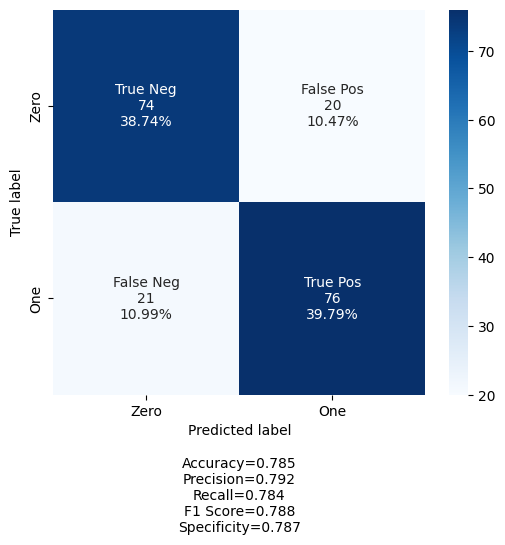

In [213]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
plt.rcParams["figure.figsize"] = (6,5)
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      )

In [214]:
for_hist = predict_for_plot(val_set_215, model_215)

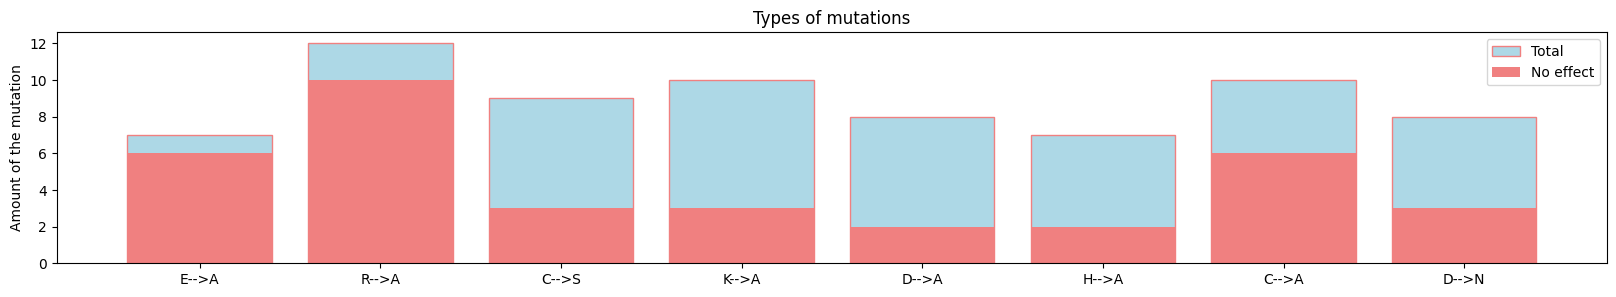

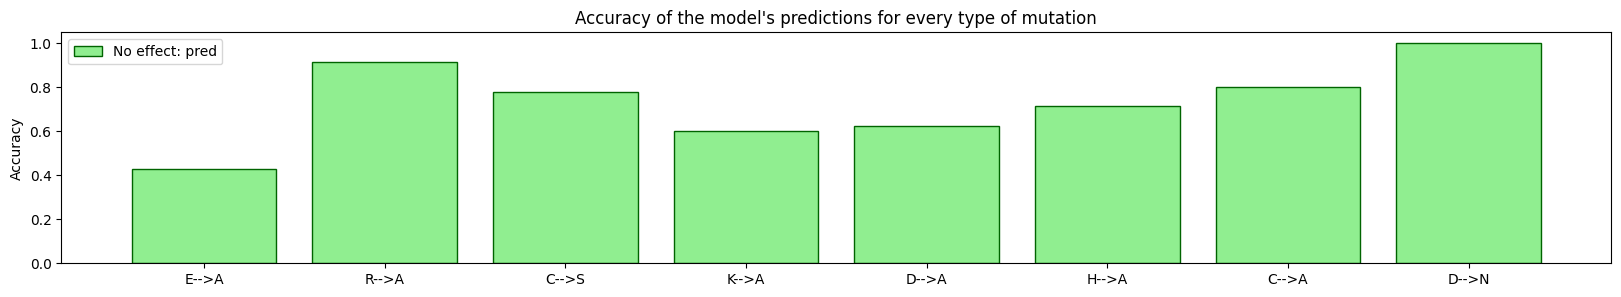

In [215]:
amount_min_of_each_plotted_mutation = 6
plot_histogram(for_hist, amount_min_of_each_plotted_mutation)

#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success">3.1.2 |</span></b> Cut 5: 5 amino acids on each side of the mutation  </div>






In [216]:
target, pred, acc = predict(val_set_cut_5, model_215)

In [217]:
cf_matrix = sklearn.metrics.confusion_matrix(target, pred)
cf_matrix

array([[45, 44],
       [46, 46]])

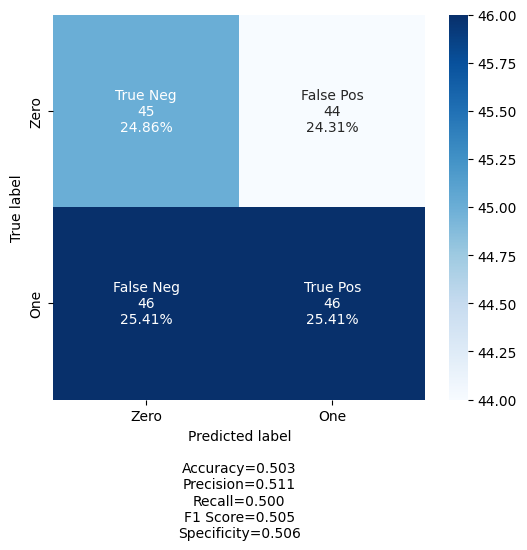

In [218]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
plt.rcParams["figure.figsize"] = (6,5)
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      )

#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success">3.1.3 |</span></b> Cut 10: 10 amino acids on each side of the mutation  </div>







In [219]:
target, pred, acc = predict(val_set_cut_10, model_215)

In [220]:
cf_matrix = sklearn.metrics.confusion_matrix(target, pred)
cf_matrix

array([[41, 48],
       [51, 41]])

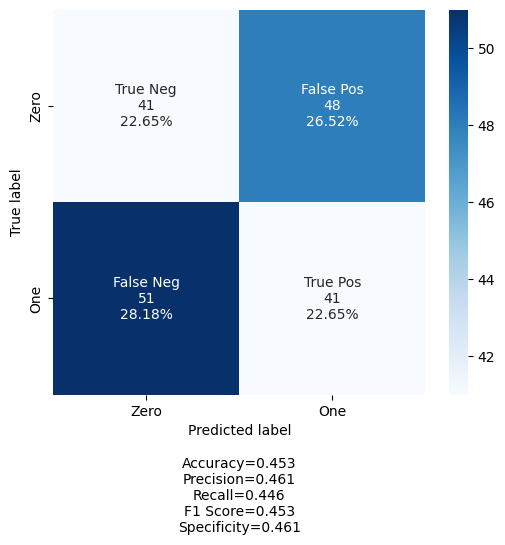

In [221]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
plt.rcParams["figure.figsize"] = (6,5)
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      )

#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success">3.1.4 |</span></b> Cut 20: 20 amino acids on each side of the mutation  </div>








In [222]:
target, pred, acc = predict(val_set_cut_20, model_215)

In [223]:
cf_matrix = sklearn.metrics.confusion_matrix(target, pred)
cf_matrix

array([[56, 33],
       [46, 46]])

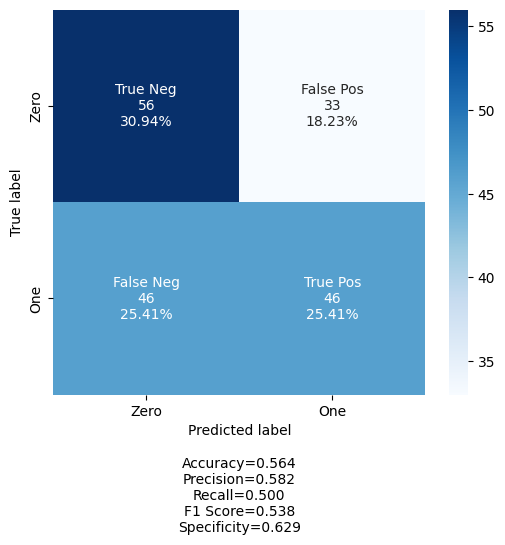

In [224]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
plt.rcParams["figure.figsize"] = (6,5)
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      )

#  <style> 
    .ma-classe {
    font-size: 30px;
}
</style>
<div class="alert alert-success">3.1.5 |</span></b> Cut 50: 50 amino acids on each side of the mutation  </div>








In [225]:
target, pred, acc = predict(val_set_cut_50, model_215)

In [226]:
cf_matrix = sklearn.metrics.confusion_matrix(target, pred)
cf_matrix

array([[55, 34],
       [44, 48]])

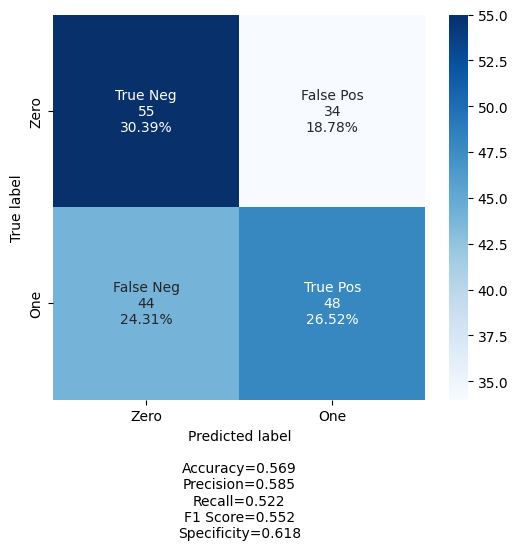

In [227]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
plt.rcParams["figure.figsize"] = (6,5)
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      )